# Environment

In [1]:
# Third-party
import multiprocessing

from pathlib import Path
from PIL import Image

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import torchvision.transforms as T
from torchvision.models import vgg19

# First-party
from data import *
from utils import *
from models.srgan import *

# Settings

In [2]:
MODEL_NAME       = "SRGAN_ALL_DATA"
TRAIN_STAGE1     = False
TRAIN_STAGE2     = True
TRAIN_DATA       = ["data/DIV2K_train_HR", "data/Flickr2K", "data/OutdoorSceneTrain_v2"]
VAL_DATA         = "./data/DIV2k_BEST_PICTURES"
DEVICE           = torch.device('cuda:1')
N_WORKERS        = 8
MONITOR_INTERVAL = 1000

# Data

In [3]:
data_mean  = [0.4439, 0.4517, 0.4054]
data_std   = [0.2738, 0.2607, 0.2856]

train_env = {}
train_env["HR_size"] = 96
train_env["LR_size"] = 96 // 4
train_env["transform"] = T.Compose([
    T.RandomCrop((train_env["HR_size"], train_env["HR_size"])),
    T.ToTensor(),
    T.Normalize(mean=data_mean, std=data_std)
])
train_env["dataset"]    = ImageDataset(TRAIN_DATA, train_env["transform"])
train_env["dataloader"] = DataLoader(train_env["dataset"], batch_size=16, shuffle=True, num_workers=N_WORKERS, pin_memory=True)

val_env = {}
val_env["HR_size"] = 1024
val_env["LR_size"] = 1024 // 4
val_env["transform"] = T.Compose([
    T.CenterCrop((val_env["HR_size"], val_env["HR_size"])),
    T.ToTensor(),
    T.Normalize(mean=data_mean, std=data_std)
])
val_env["dataset"]    = ImageDataset(VAL_DATA, val_env["transform"])
val_env["dataloader"] = DataLoader(val_env["dataset"], batch_size=3, shuffle=False, num_workers=3, pin_memory=True) 

# Training

In [4]:
generator = Generator().to(DEVICE)
    
mse_loss = torch.nn.MSELoss().to(DEVICE)

In [5]:
def stage1_training_loop(n_iterations=1e6, learning_rate=1e-4):
    writer = SummaryWriter('runs/' + MODEL_NAME + '_stage1')
    
    generator.train()
    optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate)
    
    n_mini_batches_processed = 0
    while n_mini_batches_processed < n_iterations:
        
        for hr_imgs in train_env["dataloader"]:
            hr_imgs = hr_imgs.to(DEVICE)
            lr_imgs = F.interpolate(hr_imgs, size=(train_env["LR_size"], train_env["LR_size"]), mode='bicubic', align_corners=False)
            
            optimizer.zero_grad()
            
            sr_imgs = generator(lr_imgs)
            
            loss = mse_loss(sr_imgs, hr_imgs)
            loss.backward()
            optimizer.step()
            
            n_mini_batches_processed += 1        
            if n_mini_batches_processed % MONITOR_INTERVAL == 0:
                
                print(f"{n_mini_batches_processed} mini-batches done. Loss: {loss}")
                writer.add_scalar('Loss', loss.item(), n_mini_batches_processed)
                
                with torch.no_grad():
                    hr_imgs = next(iter(val_env['dataloader']))
                    hr_imgs = hr_imgs.to(DEVICE)
                    lr_imgs = F.interpolate(hr_imgs, size=(val_env["LR_size"], val_env["LR_size"]), mode='bicubic', align_corners=False)
                    sr_imgs = generator(lr_imgs)
                
                sr_imgs = denormalize(sr_imgs.cpu().detach())
                
                writer.add_image('SR Butterfly', sr_imgs[0], n_mini_batches_processed)
                writer.add_image('SR Food', sr_imgs[1], n_mini_batches_processed)
                writer.add_image('SR House', sr_imgs[2], n_mini_batches_processed)
                
    writer.close()
    
if TRAIN_STAGE1:
    #stage1_training_loop()
    stage1_training_loop(n_iterations=2e5) # Deviates from the paper but 1e6 is too much for us

In [6]:
PATH = "trained_models/" + MODEL_NAME + "_stage1_generator.trch"

if TRAIN_STAGE1:
    torch.save(generator.state_dict(), PATH)
else:
    generator.load_state_dict(torch.load(PATH))

In [7]:
discriminator = Discriminator().to(DEVICE)

vgg19_model     = vgg19(pretrained=True, num_classes=1000).to(DEVICE)
vgg_19_54_model = vgg19_model.features[:36]

vgg_19_54_model.eval()
for parameters in vgg_19_54_model.parameters():
    parameters.requires_grad = False

def content_loss(hr_imgs, sr_imgs):
    # One should probably normalize the HR images based on ImageNet for this, but ImageNet has very similar mean/std to our dataset.
    hr_features = vgg_19_54_model(hr_imgs)
    sr_features = vgg_19_54_model(sr_imgs)
    return 0.006 * F.mse_loss(sr_features, hr_features)

adversarial_loss = torch.nn.BCELoss().to(DEVICE)

In [8]:
def stage2_training_loop(n_iterations=2*1e5, learning_rate=1e-4):
    writer = SummaryWriter('runs/' + MODEL_NAME + '_stage2')
    
    generator.train()
    g_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate)
    g_scheduler = torch.optim.lr_scheduler.StepLR(g_optimizer, step_size=n_iterations//2, gamma=0.1)
    
    discriminator.train()
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)
    d_scheduler = torch.optim.lr_scheduler.StepLR(d_optimizer, step_size=n_iterations//2, gamma=0.1)
    
    n_mini_batches_processed = 0
    while n_mini_batches_processed < n_iterations:
        
        for hr_imgs in train_env["dataloader"]:
            hr_imgs = hr_imgs.to(DEVICE)
            lr_imgs = F.interpolate(hr_imgs, size=(train_env["LR_size"], train_env["LR_size"]), mode='bicubic', align_corners=False)
            
            zeros = torch.zeros((hr_imgs.size()[0], 1)).to(DEVICE)
            ones = torch.ones((hr_imgs.size()[0], 1)).to(DEVICE)
            
            # Discriminator's turn
            d_optimizer.zero_grad()
            
            loss1 = adversarial_loss(discriminator(hr_imgs), ones)
            
            sr_imgs = generator(lr_imgs)
            loss2 = adversarial_loss(discriminator(sr_imgs.detach()), zeros)
            
            d_loss = loss1 + loss2 # Equation 2
            d_loss.backward()
            
            d_optimizer.step()
            d_scheduler.step()
            
            # Generator's turn
            g_optimizer.zero_grad()
            
            sr_imgs = generator(lr_imgs)
            
            g_loss = mse_loss(sr_imgs, hr_imgs.detach()) + content_loss(hr_imgs.detach(), sr_imgs) + 1e-3 * adversarial_loss(discriminator(sr_imgs), ones)
            g_loss.backward()
            
            g_optimizer.step()
            g_scheduler.step()
            
            # Monitor
            n_mini_batches_processed += 1
            if n_mini_batches_processed % MONITOR_INTERVAL == 0:
                
                print(f"{n_mini_batches_processed} mini-batches done. Discriminator loss: {d_loss}. Generator loss: {g_loss}")
                writer.add_scalar('Generator Loss', g_loss.item(), n_mini_batches_processed)
                writer.add_scalar('Discriminator Loss', d_loss.item(), n_mini_batches_processed)
                
                with torch.no_grad():
                    hr_imgs = next(iter(val_env['dataloader']))
                    hr_imgs = hr_imgs.to(DEVICE)
                    lr_imgs = F.interpolate(hr_imgs, size=(val_env["LR_size"], val_env["LR_size"]), mode='bicubic', align_corners=False)
                    sr_imgs = generator(lr_imgs)
                
                sr_imgs = denormalize(sr_imgs.cpu().detach())
                
                writer.add_image('SR Butterfly', sr_imgs[0], n_mini_batches_processed)
                writer.add_image('SR Food', sr_imgs[1], n_mini_batches_processed)
                writer.add_image('SR House', sr_imgs[2], n_mini_batches_processed)
                
    writer.close()

if TRAIN_STAGE2:
    stage2_training_loop()

1000 mini-batches done. Discriminator loss: 0.1106223315000534. Generator loss: 0.11957353353500366
2000 mini-batches done. Discriminator loss: 0.11848852783441544. Generator loss: 0.05021794140338898
3000 mini-batches done. Discriminator loss: 0.03824423998594284. Generator loss: 0.09506640583276749
4000 mini-batches done. Discriminator loss: 0.0094051044434309. Generator loss: 0.06608904153108597
5000 mini-batches done. Discriminator loss: 0.0033958859276026487. Generator loss: 0.08378443866968155
6000 mini-batches done. Discriminator loss: 0.29684650897979736. Generator loss: 0.03180725499987602
7000 mini-batches done. Discriminator loss: 0.02672462910413742. Generator loss: 0.07945043593645096
8000 mini-batches done. Discriminator loss: 0.00636373832821846. Generator loss: 0.08152284473180771
9000 mini-batches done. Discriminator loss: 0.018985886126756668. Generator loss: 0.06769939512014389
10000 mini-batches done. Discriminator loss: 0.44235846400260925. Generator loss: 0.036854

81000 mini-batches done. Discriminator loss: 1.2665992699112394e-07. Generator loss: 0.08605057001113892
82000 mini-batches done. Discriminator loss: 0.006685683969408274. Generator loss: 0.08847222477197647
83000 mini-batches done. Discriminator loss: 0.00017388856213074178. Generator loss: 0.09329685568809509
84000 mini-batches done. Discriminator loss: 0.00012059814616804942. Generator loss: 0.07119464129209518
85000 mini-batches done. Discriminator loss: 6.891867087688297e-05. Generator loss: 0.10561104118824005
86000 mini-batches done. Discriminator loss: 0.00014142415602691472. Generator loss: 0.10014211386442184
87000 mini-batches done. Discriminator loss: 4.133511538384482e-05. Generator loss: 0.10209962725639343
88000 mini-batches done. Discriminator loss: 1.0076999387820251e-05. Generator loss: 0.10442179441452026
89000 mini-batches done. Discriminator loss: 1.1533582437550649e-05. Generator loss: 0.07970249652862549
90000 mini-batches done. Discriminator loss: 3.311792852400

164000 mini-batches done. Discriminator loss: 0.0. Generator loss: 0.14167770743370056
165000 mini-batches done. Discriminator loss: 0.0. Generator loss: 0.09628906100988388
166000 mini-batches done. Discriminator loss: 0.0. Generator loss: 0.12134337425231934
167000 mini-batches done. Discriminator loss: 0.0. Generator loss: 0.11378490179777145
168000 mini-batches done. Discriminator loss: 0.0. Generator loss: 0.11871671676635742
169000 mini-batches done. Discriminator loss: 0.0. Generator loss: 0.11493950337171555
170000 mini-batches done. Discriminator loss: 0.0. Generator loss: 0.11173659563064575
171000 mini-batches done. Discriminator loss: 0.0. Generator loss: 0.10607724636793137
172000 mini-batches done. Discriminator loss: 0.0. Generator loss: 0.19383369386196136
173000 mini-batches done. Discriminator loss: 0.0. Generator loss: 0.06500954926013947
174000 mini-batches done. Discriminator loss: 0.0. Generator loss: 0.13272970914840698
175000 mini-batches done. Discriminator los

In [9]:
G_PATH = "trained_models/" + MODEL_NAME + "_stage2_generator.trch"
D_PATH = "trained_models/" + MODEL_NAME + "_stage2_discriminator.trch"

if TRAIN_STAGE2:
    torch.save(generator.state_dict(), G_PATH)
    torch.save(discriminator.state_dict(), D_PATH)
else:
    generator.load_state_dict(torch.load(G_PATH))
    discriminator.load_state_dict(torch.load(D_PATH))

# Evaluation

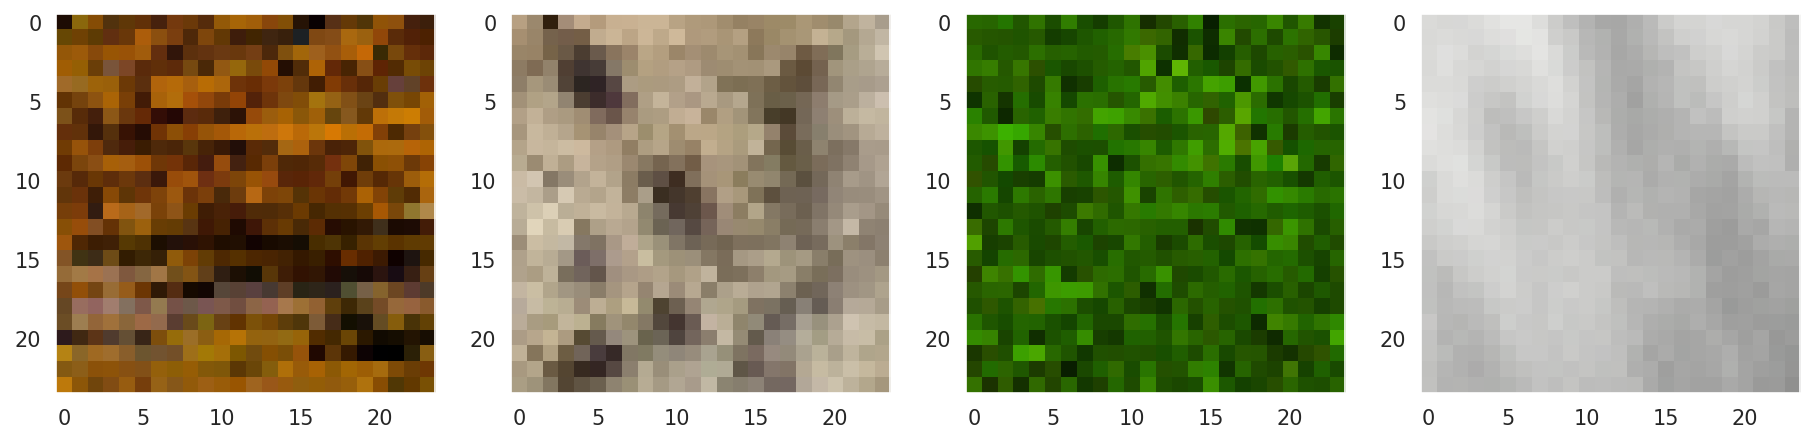

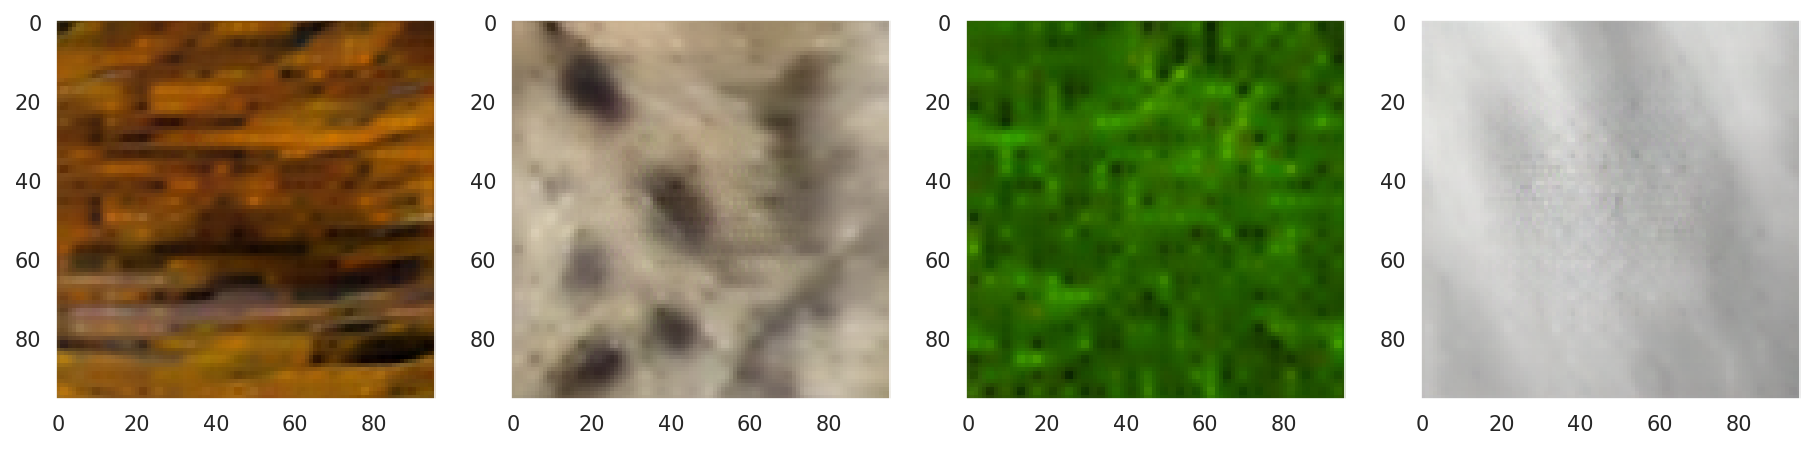

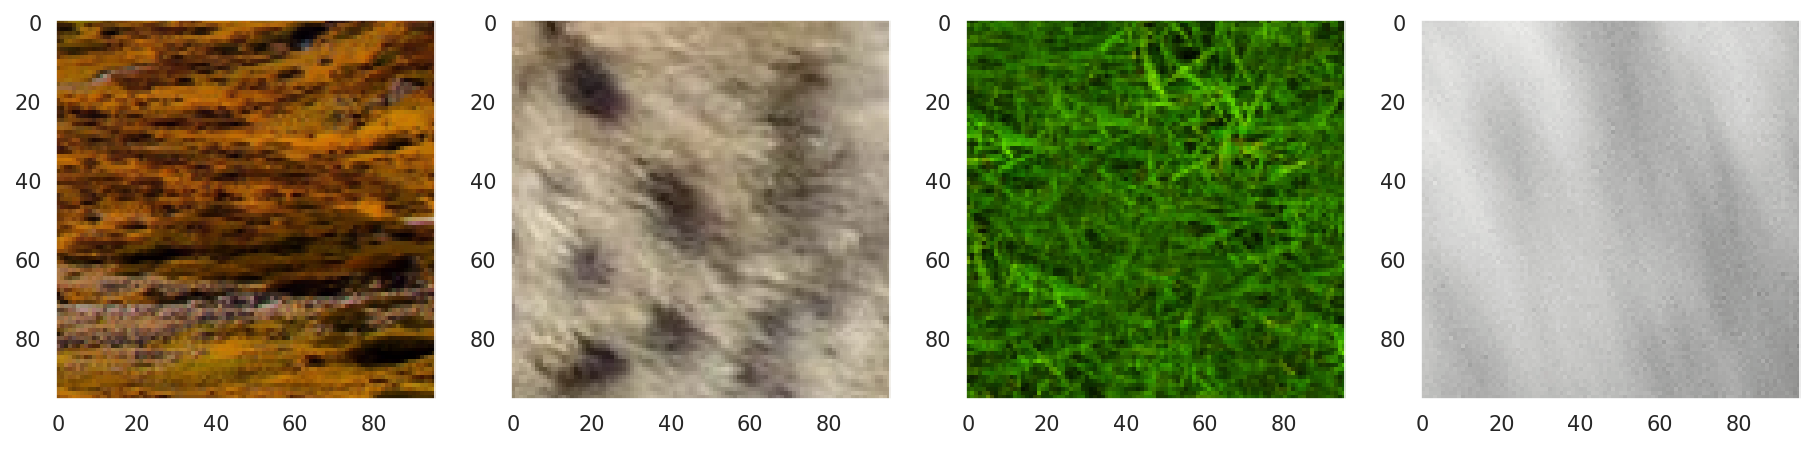

In [10]:
with torch.no_grad():
    hr_imgs = next(iter(train_env['dataloader']))[:4,]
    hr_imgs = hr_imgs.to(DEVICE)
    lr_imgs = F.interpolate(hr_imgs, size=(train_env["LR_size"], train_env["LR_size"]), mode='bicubic', align_corners=False)
    sr_imgs = generator(lr_imgs)
    
    plot_images(denormalize(lr_imgs.cpu().detach()))
    plot_images(denormalize(sr_imgs.cpu().detach()))
    plot_images(denormalize(hr_imgs.cpu().detach()))

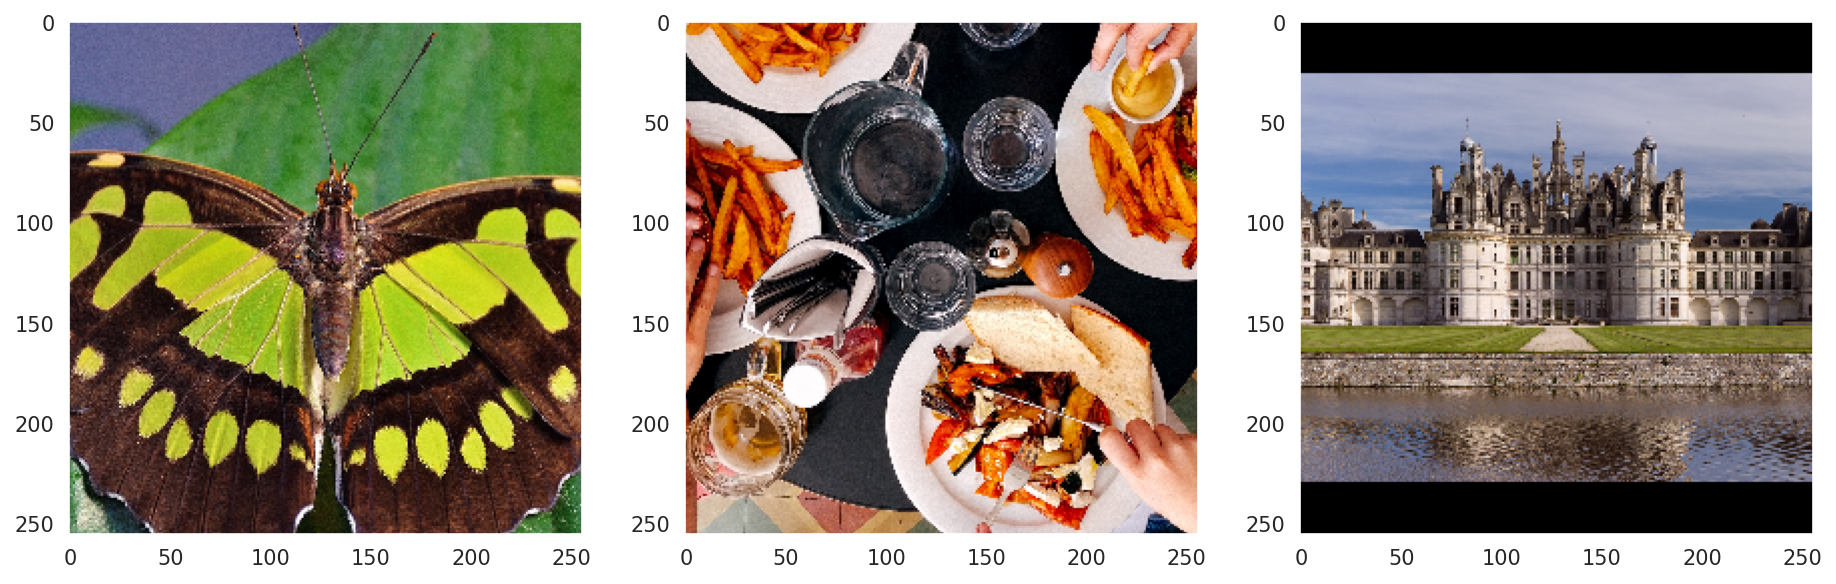

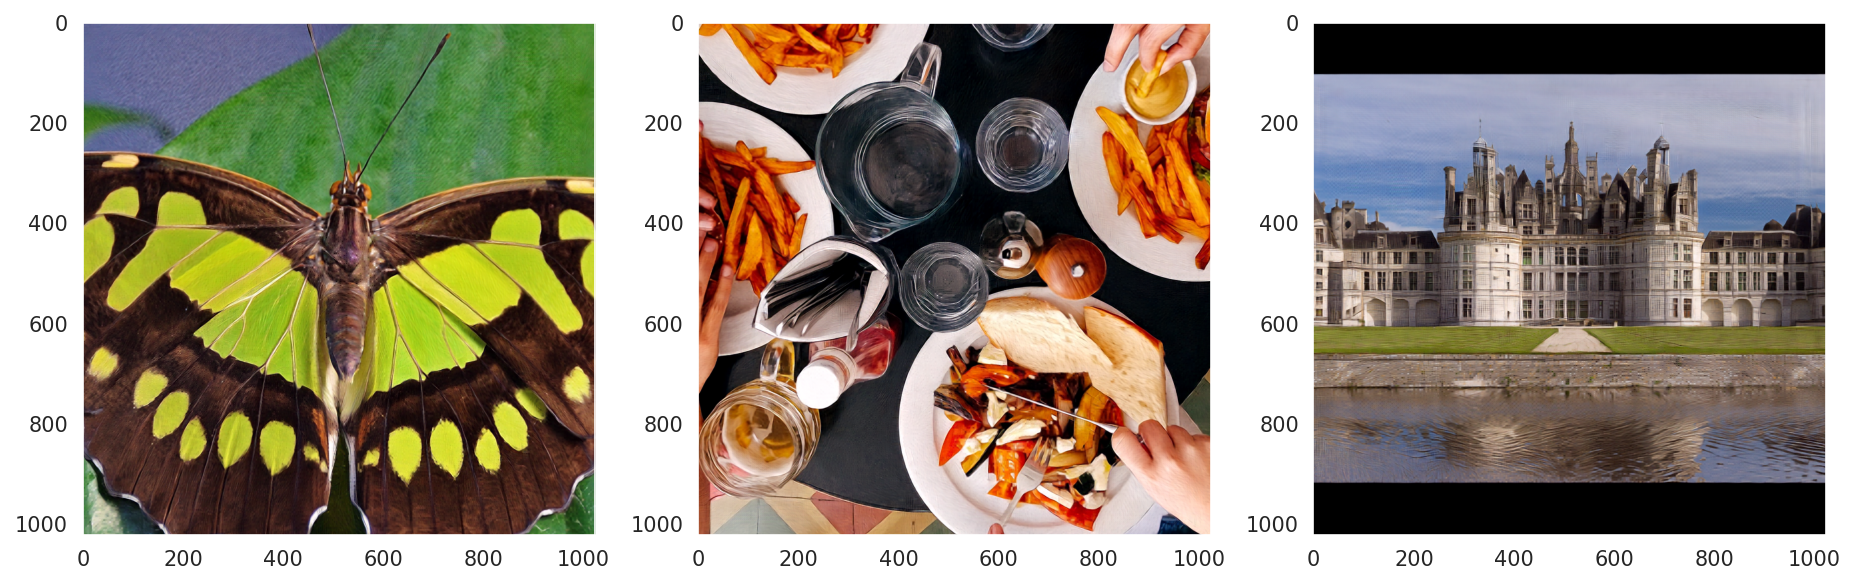

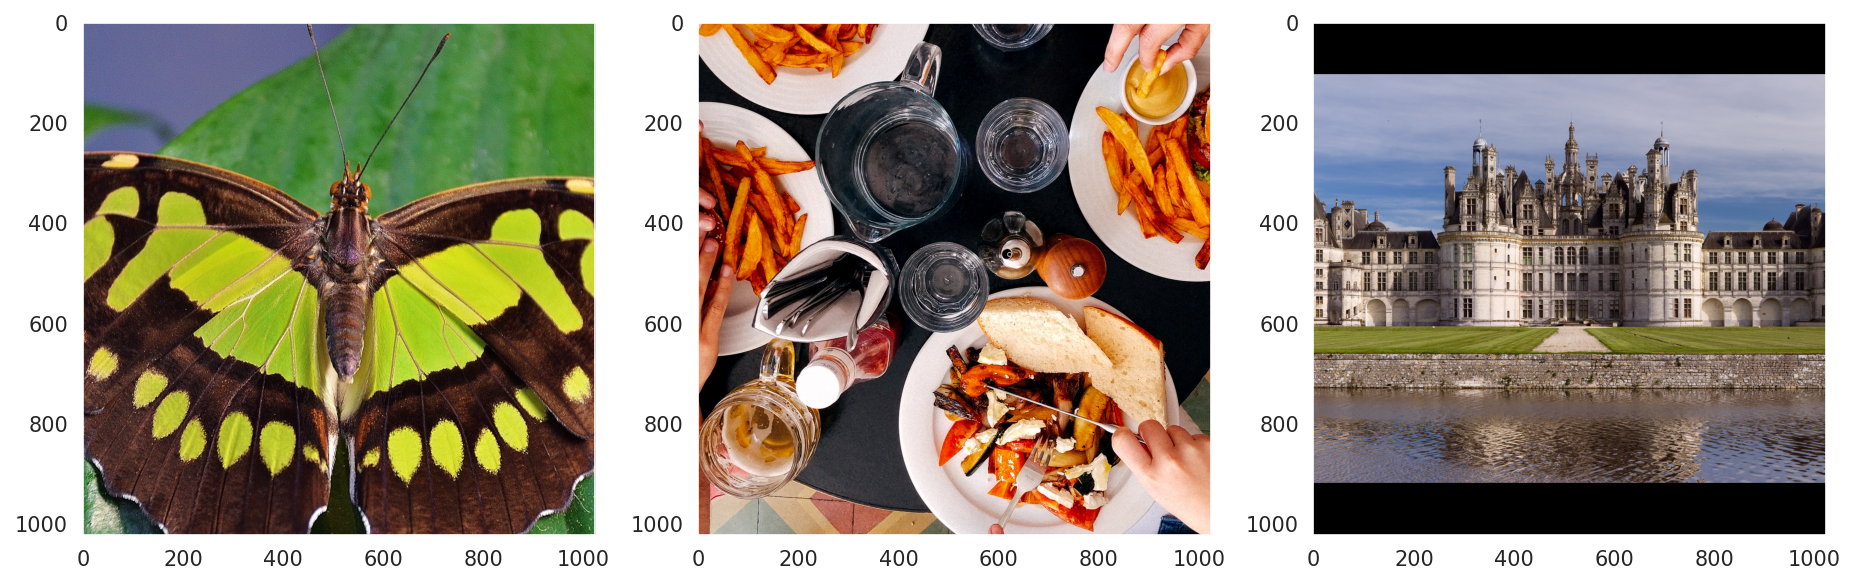

In [11]:
with torch.no_grad():
    hr_imgs = next(iter(val_env['dataloader']))
    hr_imgs = hr_imgs.to(DEVICE)
    lr_imgs = F.interpolate(hr_imgs, size=(val_env["LR_size"], val_env["LR_size"]), mode='bicubic', align_corners=False)
    sr_imgs = generator(lr_imgs)
    
    plot_images(denormalize(lr_imgs.cpu().detach()))
    plot_images(denormalize(sr_imgs.cpu().detach()))
    plot_images(denormalize(hr_imgs.cpu().detach()))